In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import svd
from scipy.signal import convolve, convolve2d
from scipy.signal import find_peaks

#### Demonstration of singular value decomposition and matching pursuit

The goal of this notebook is to demonstrate some basic algorithms used in Kilosort. Kilosort depends upon singular value decomposition (SVD) to denoise spike waveform templates and speed up its calculations. In addition, Kilosort uses matching pursuit to identify spikes in a recording and handle the problem of their overlap. To show how matching pursuit works, we also have to discuss convolution.

### Load spike data from ClassicSortingDemo

To start, let's load our recording and the spike waveforms we generated using our classic spike sorting algorithm (see ClassicSortingDemo.ipynb).

In [42]:
chan_num = 8
spk_waves = np.load('../Data/SpikeWaveforms.npy')
rec = np.load('../Data/FiltRecording.npy')

Our spike waveforms array, *spk_waves*, has 3 dimensions. The first dimension specifies the spike, the second the channel, and the third is time. Let's find the spike that had to largest amplitude and plot its waveform as a matrix (channel **X** time).

In [24]:
spk_wave_peaks = np.amax(np.abs(spk_waves),axis=(1,2))
spk_biggest = spk_wave_peaks.argmax()
print("Spike waveform at index {} had the largest peak".format(spk_biggest))


Spike waveform at index 2 had the largest peak


Text(50.722222222222214, 0.5, 'Channels')

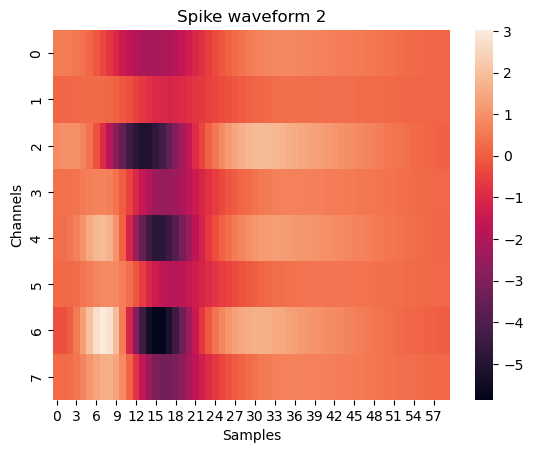

In [25]:

fig, ax = plt.subplots()
sel_wave = spk_waves[spk_biggest,:,:].squeeze();
sns.heatmap(sel_wave, ax=ax)
ax.set_title("Spike waveform {}".format(spk_biggest))
ax.set_xlabel('Samples')
ax.set_ylabel('Channels')

#### SVD

SVD is a matrix factorization technique that takes a matrix and returns three new matrices, *U*, *s*, and *V*. *U* is an orthonormal basis, with each column being orthogonal to all the others. *V* is also an orthonormal basis, with each row being orthogonal its others. *s* is a diagonal matrix of singular values, which scales each basis. The bases are in descending order by their singular values. If you multiply *U* **X** *s* **X** *V\** together you get the original matrix. Let's try SVD on the spike waveform we plotted above.

In [26]:
u,s,vh = svd(sel_wave)

# since svd returns a vector for s, we will covert it to a diagonal matrix
# for agreement with convention
s = np.diag(s)

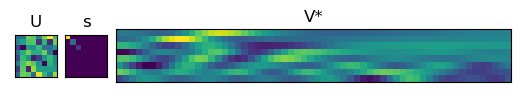

In [27]:
# plot matrices returned by SVD
fig = plt.figure()
gs = fig.add_gridspec(1,10)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2:])
ax0.matshow(u)
ax0.set_title('U')
ax0.set_xticks([])
ax0.set_yticks([])
ax1.matshow(s)
ax1.set_title('s')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.matshow(vh[0:chan_num,:])
ax2.set_title('V*')
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

You should see that each column of *U* is a distinct pattern across the channels. Indeed, the first column appears to show the alternating strength of the spike waveform between even and odd channels. The *s* matrix is diagonal with the strongest elements at the top left and weakest in the bottom right. These are the singular values. The rows of *V\** capture the time course of the spike waveform.

An advantage of SVD is that we can reconstruct the original matrix using parts of these matrices. If we just use the first column of *U*, singular value of *s*, and row of *V\**, then we have created a rank 1 version of our original matrix.

Text(0.5, 1.0, 'Black = Original, Red = Rank 1')

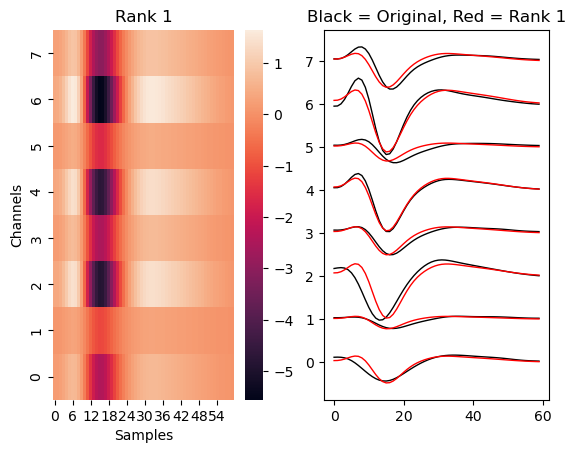

In [28]:
# use matrix multiplication to create the rank 1 version of the spike waveform
sel_wave_r1 = np.matmul(u[:,0:1]*s[0:1,0:1],vh[0:1,:])

# define a plotting function for drawing multichannel
# time series data
def multichanplot(data,color,ax,offset=5):
    line_num = data.shape[0]
    data_off = np.arange(0,line_num)*offset
    ax.plot(data.T+data_off, linewidth=1, linestyle='-', color=color)
    ax.set_yticks(data_off)
    ax.set_yticklabels(["{}".format(x) for x in range(line_num)])

# plot the matrix representation of the reconstruction and
# the reconstruction overlaid on the original waveform 
fig, ax = plt.subplots(1,2)
sns.heatmap(sel_wave_r1,ax=ax[0])
ax[0].set_title('Rank 1')
ax[0].set_xlabel('Samples')
ax[0].set_ylabel('Channels')
ax[0].invert_yaxis()
multichanplot(sel_wave,[0,0,0],ax[1])
multichanplot(sel_wave_r1,[1,0,0],ax[1])
ax[1].set_title('Black = Original, Red = Rank 1')


You can see from this that the rank 1 reconstruction of the waveform captures the variations in spike amplitude across channels, and the principal features of the waveform. But, there are subtle differences in the waveform shape across channels are not well represented. To improve the reconstruction, we can add the second components from the SVD matrices. The math is the same, but this time we take the first two columns of *U*, first two singular values of *s*, and first two rows of *V\**.

Text(0.5, 1.0, 'Black = Original, Red = Rank 2')

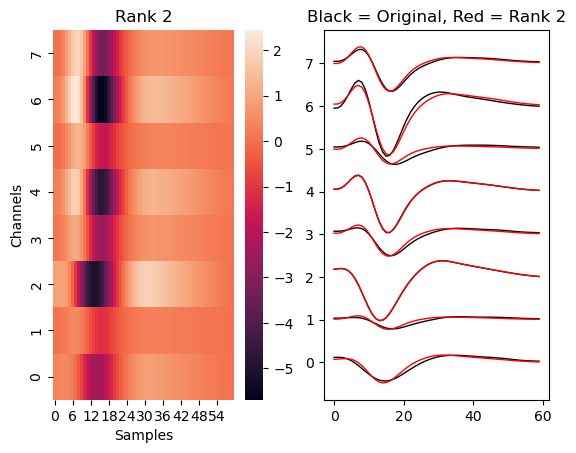

In [29]:
# use matrix multiplication to create the rank 2 version of the spike waveform
sel_wave_r2 = np.matmul(np.matmul(u[:,0:2],s[0:2,0:2]),vh[0:2,:])

fig, ax = plt.subplots(1,2)
sns.heatmap(sel_wave_r2,ax=ax[0])
ax[0].set_title('Rank 2')
ax[0].set_xlabel('Samples')
ax[0].set_ylabel('Channels')
ax[0].invert_yaxis()

multichanplot(sel_wave,[0,0,0],ax[1])
multichanplot(sel_wave_r2,[1,0,0],ax[1])
ax[1].set_title('Black = Original, Red = Rank 2')

Now the original and reconstruction match much better. The addition of the second component has shifted the waveform to peak earlier on the channels where it needed to. This should not come as a surprise since the second row of *V\** had a peak earlier than that in the first row, and it had a strong weight on channel 2 whose waveform peaked earlier than the others. To make the fit even better, we can add the third component for a rank 3 reconstruction.

Text(0.5, 1.0, 'Black = Original, Red = Rank 3')

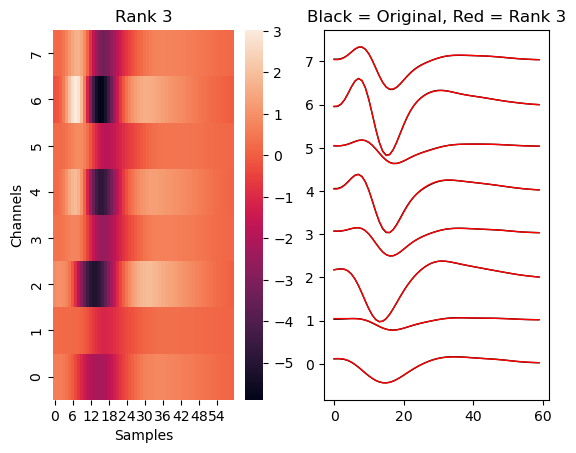

In [30]:
# use matrix multiplication to create the rank 3 version of the spike waveform
sel_wave_r3 = np.matmul(np.matmul(u[:,0:3],s[0:3,0:3]),vh[0:3,:])

fig, ax = plt.subplots(1,2)
sns.heatmap(sel_wave_r3,ax=ax[0])
ax[0].set_title('Rank 3')
ax[0].set_xlabel('Samples')
ax[0].set_ylabel('Channels')
ax[0].invert_yaxis()

multichanplot(sel_wave,[0,0,0],ax[1])
multichanplot(sel_wave_r3,[1,0,0],ax[1])
ax[1].set_title('Black = Original, Red = Rank 3')

Notice how the black lines corresponding to the original spike waveform have vanished. This means our reconstruction is virtually identical to the original and perfectly overlays it.

Crucially, this means we no longer require an entire spike waveform template. Instead, we can just take the first three columns of *U*, singular values of *s*, and rows of *V\**. The full spike waveform template had *channels* **X** *samples* datapoints, in our case 8 **X** 60 = 480 data points. If we take the SVD components for a rank 3 reconstruction, then we need (*channels* **X** *rank*) + (*samples* **X** *rank*) + *rank* data points, which here is (8 **X** 3) + (60 **X** 3) + 3 = 24 + 180 + 3 = 207. This cuts the number of values in more than half.

Reducing the number of data points needed to represent a spike waveform will speed up calculations used to detect spikes in our recorded data. To see this, we have to discuss convolution.

#### Convolution

One way we can detect times when a spike arose from a specific neuron is to slide its template along the entire recording and identify times when it matches. This operation is known as convolution. The scipy package provides a convolution function that works with 2 dimensional data, which we have since there is a channels dimension and time dimension for both our spike waveform and recording.

Let's visualize this with a snippet of our recording and the selected spike waveform we have been working with. For this first example we will use the full template.

Text(0, 0.5, 'Channels')

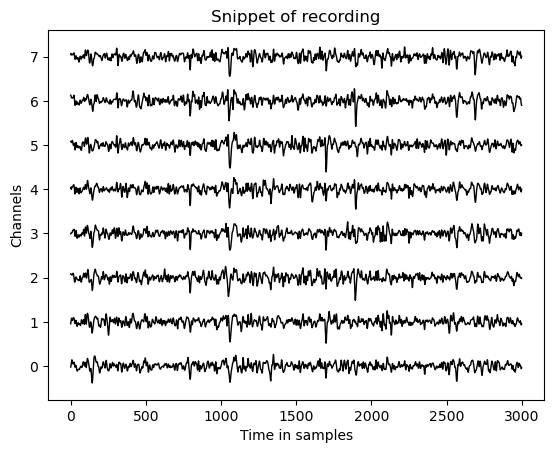

In [43]:
# getting a 100 milisecond snippet where our unit fired. 
rec_snip = rec[1000:4000,:].copy()

fig, ax = plt.subplots()
multichanplot(rec_snip.T,[0,0,0],ax,offset=20)
ax.set_title('Snippet of recording')
ax.set_xlabel('Time in samples')
ax.set_ylabel('Channels')

Here we can see many spikes occurring, but our selected waveform only occurs around time point 1900. Can convolution identify that time point?

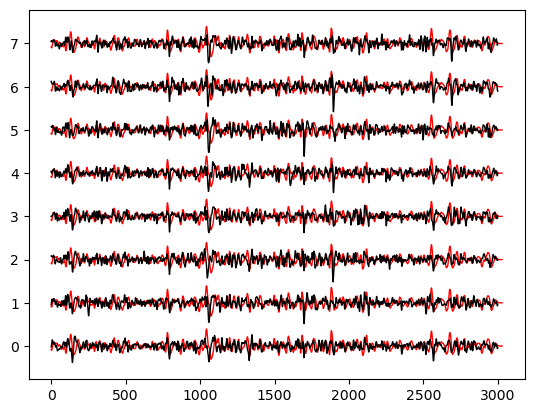

In [32]:
# We first adjust the selected waveform to make make
# it suitable for convolution.
sel_wave_conv = sel_wave.T/np.linalg.norm(sel_wave)

conv_ser = convolve2d(rec_snip,sel_wave_conv)

# we only care about the convolution where the channels agreed, 
# i.e. chan 0 -> chan 0, chan 1 -> chan 1, etc, so we select the 
# middle convolution
conv_ser = np.tile(np.reshape(conv_ser[30:,8]/5,(-1,1)),(1,chan_num))

fig, ax = plt.subplots()
multichanplot(conv_ser.T,[1,0,0],ax,offset=20)
multichanplot(rec_snip.T,[0,0,0],ax,offset=20)


Notice how the red time series peaks whenever a spike occurs. This is because most spike waveforms are pretty similar. Indeed, the strongest peak is not for our unit around sample 1100. However, if we convolved the time series with a different spike waveform that better fit that wave, it would have a stronger convolution peak and thus we would assign that spike to the other unit.

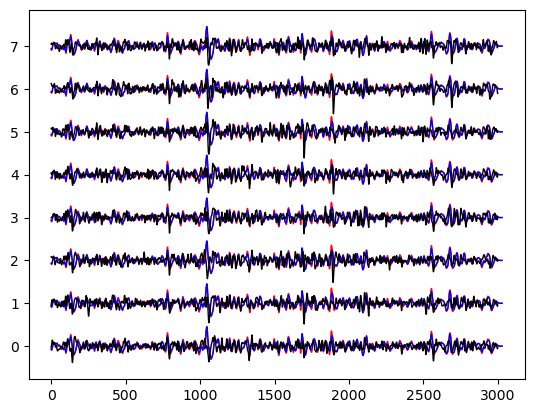

In [33]:
# create a new waveform for convolution
sel_wave2_conv = spk_waves[4,:,:].squeeze().T/np.linalg.norm(sel_wave)

conv_ser2 = convolve2d(rec_snip,sel_wave2_conv)

# we only care about the convolution where the channels agreed, 
# i.e. chan 0 -> chan 0, chan 1 -> chan 1, etc, so we select the 
# middle convolution
conv_ser2 = np.tile(np.reshape(conv_ser2[30:,8]/5,(-1,1)),(1,chan_num))

fig, ax = plt.subplots()
multichanplot(conv_ser.T,[1,0,0],ax,offset=20)
multichanplot(conv_ser2.T,[0,0,1],ax,offset=20)
multichanplot(rec_snip.T,[0,0,0],ax,offset=20)


Notice that the 'blue' waveform peaks at sample 1100 higher than the 'red', and vice versa at sample 1900. This indicates that the spike happening at sample 1100 more likely came from the newly selected waveform, while the one at 1900 came from our previously selected waveform. Zooming in makes this clearer.

Text(0.5, 1.0, 'Spike near 1900')

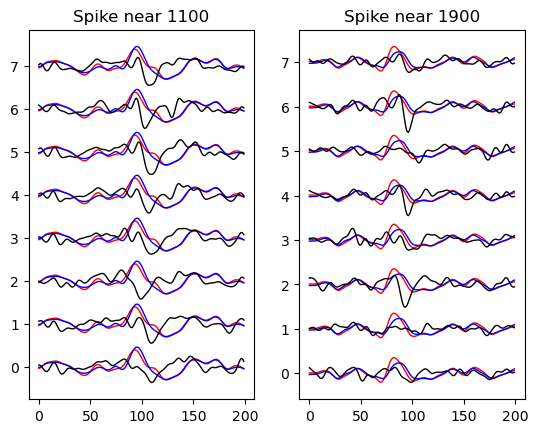

In [34]:
fig, ax = plt.subplots(1,2)
multichanplot(conv_ser[950:1150,:].T,[1,0,0],ax[0],offset=20)
multichanplot(conv_ser2[950:1150,:].T,[0,0,1],ax[0],offset=20)
multichanplot(rec_snip[950:1150,:].T,[0,0,0],ax[0],offset=20)
ax[0].set_title('Spike near 1100')

multichanplot(conv_ser[1800:2000,:].T,[1,0,0],ax[1],offset=20)
multichanplot(conv_ser2[1800:2000,:].T,[0,0,1],ax[1],offset=20)
multichanplot(rec_snip[1800:2000,:].T,[0,0,0],ax[1],offset=20)
ax[1].set_title('Spike near 1900')

So far we have performed convolution with the full template. This entails many computations, which for a large recording would take a long time to carry out. To speed things up, we can perform convolution using the low-rank version of the spike waveform. This is an implementation of equation 5 in the Kilosort paper that shows how to do convolution with the SVD matrices. All variable names have been changed to match those in the paper.

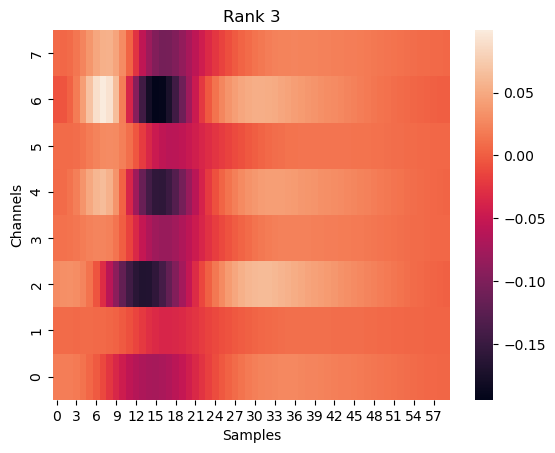

In [35]:
# we have to recalculate the SVD to make the low-rank approximation of
# convolution kernel
A = sel_wave
v = rec_snip.T
U, s, W = svd(A)

# we have to normalize the low rank template and scale components
# by the singular values (which is not discussed in the Kilosort paper)
U = U[:,0:3]*s[0:3]
W = W[0:3,:]
U = U/np.linalg.norm(np.matmul(U,W))

# let's plot the template to make sure all is well
fig, ax = plt.subplots()
sns.heatmap(np.matmul(U,W))
ax.set_title('Rank 3')
ax.set_xlabel('Samples')
ax.set_ylabel('Channels')
ax.invert_yaxis()

Now that we have a low rank template, we will apply it to the recording snippet. 

Text(0.5, 1.0, 'Black is original, red is full template convolution, green is low rank')

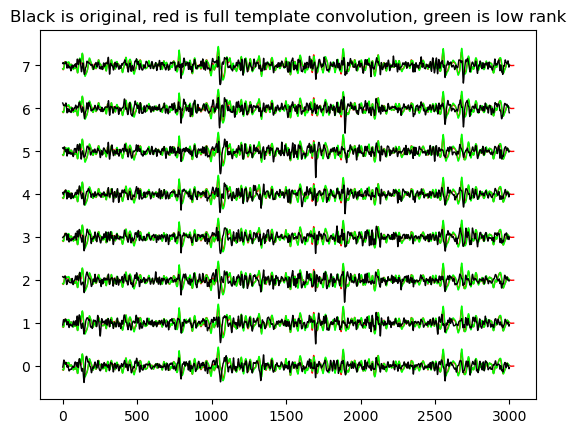

In [36]:
# first we apply the channel component
conv_ser_lr = np.zeros((3000,3))
for j in range(3):
    conv_ser_lr[:,j] = convolve(np.matmul(U[:,j].T,v),W[j,:],mode='same')

conv_ser_lr = np.sum(conv_ser_lr,1)
conv_ser_lr = np.tile(conv_ser_lr,(chan_num,1))/5

# plot the 
fig, ax = plt.subplots()
multichanplot(conv_ser.T,[1,0,0],ax,offset=20)
multichanplot(conv_ser_lr,[0,1,0],ax,offset=20)
multichanplot(rec_snip.T,[0,0,0],ax,offset=20)
ax.set_title('Black is original, red is full template convolution, green is low rank')

Seems like our low rank convolution matches, zooming in on the spikes we previously inspected should make this clearer.

Text(0.5, 1.0, 'Spike near 1900')

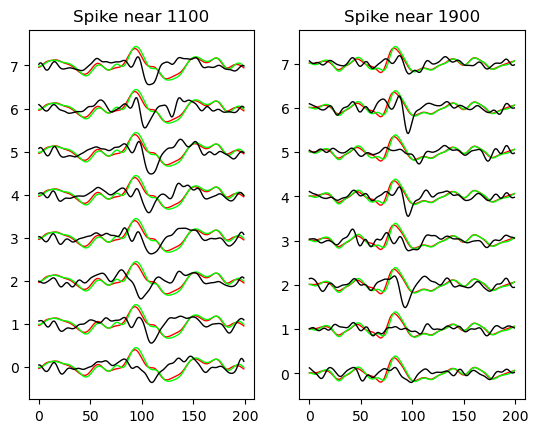

In [37]:
fig, ax = plt.subplots(1,2)
multichanplot(conv_ser[950:1150,:].T,[1,0,0],ax[0],offset=20)
multichanplot(conv_ser_lr[:,950:1150],[0,1,0],ax[0],offset=20)
multichanplot(rec_snip[950:1150,:].T,[0,0,0],ax[0],offset=20)
ax[0].set_title('Spike near 1100')

multichanplot(conv_ser[1800:2000,:].T,[1,0,0],ax[1],offset=20)
multichanplot(conv_ser_lr[:,1800:2000],[0,1,0],ax[1],offset=20)
multichanplot(rec_snip[1800:2000,:].T,[0,0,0],ax[1],offset=20)
ax[1].set_title('Spike near 1900')

As you can see, the match between the full template convolution (red) and the low rank convolution (green) is very close. Since the low rank convolution uses fewer calculations, it is the better choice since convolution is the backbone of the Kilosort algorithm.

#### Matching pursuit

Matching pursuit is an algorithm seeks to recreate a signal by inserting and rescaling template waveforms from a dictionary. In our case, the dictionary is our set of spike waveforms, while the signal is our recording snippet. Each template is convolved with the signal and the one with the strongest peak is chosen and inserted into a new signal at the time of the peak. It is then subtracted from the original signal, and the process rerun to find the next strongest template. This template is then added into the new signal and subtracted from the original. This goes on until some criterion is reached. 

With regard to spike sorting, we are not constructing a new signal, instead we just care about finding the time when the spike occured and which waveform it corresponded to. Kilosort does this without subtraction when optimizing the waveforms, but for its final detection/sorting pass through the data it does do the subtration to detect overlapping spikes.

Here we will bring together the SVD reconstruction and convolution we covered before to perform a simple version of matching pursuit with our spike waveforms.

In [85]:
# The functions below will be used for implementing matching pursuit

# create low rank templates with SVD for each spike waveform
def template_lr(waves, rank=3):
    wave_num = waves.shape[0]
    waves_lr = list()
    for j in range(wave_num):
        U,s,V = svd(spk_waves[j,:,:].squeeze())
        U = U[:,0:rank]*s[0:rank]
        U = U/np.linalg.norm(np.matmul(U,V[0:rank,:]))
        V = V[0:rank,:]
        T = np.matmul(U,V)
        waves_lr.append({'U':U, 'W':V, 'T':T})
    
    return waves_lr

# since we will rerun the low rank convolution multiple times, we
# should create a dedicated function for it
def convolve_lr(sig, svd_dict):
    dict_num = len(svd_dict)
    sig_len = sig.shape[1]
    sig_conv = np.zeros((dict_num,sig.shape[1]))
    for j in range(dict_num):
        U_curr = svd_dict[j]['U']
        W_curr = svd_dict[j]['W']
        rank_curr = U_curr.shape[1]
        conv_curr = np.zeros((rank_curr, sig_len))
        for k in range(rank_curr):
            conv_curr[k,:] = convolve(np.matmul(U_curr[:,k].T,sig),W_curr[k,:],mode='same')
        sig_conv[j,:]= np.sum(conv_curr,0)
    
    return sig_conv

# finds the spike waveform, time, and scaling that had the best match
def bestmatch(sig_conv, sig, svd_dict):
    sig_conv[np.where(sig_conv<0)] = 0
    wave_best = np.argmax(conv_temp.max(1))
    samp_best = np.argmax(conv_temp[wave_best,:])

    # scaling factor for best waveform is calculated by dividing the 
    # magnitude of the waveform sample in the signal by the magnitude
    # of the best waveform
    item_best = svd_dict[wave_best]['T']
    item_len = item_best.shape[1]
    sig_samp_inds = samp_best+list(range(item_len))-1
    sig_best = sig[:,sig_samp_inds]
    scale_best = np.linalg.norm(sig_best)/np.linalg.norm(item_best)
    
    return {'item':wave_best, 'sample':samp_best, 
            'scale':scale_best, 'inds':sig_samp_inds}

# creates reconstructed and differenced signals
def reconstruct(sig_o, sig_r, bm, svd_dict):
    if len(sig_r) == 0:
        sig_r = np.zeros(sig_o.shape)
    
    item_insert = svd_dict[bm['item']]['T']*bm['scale']
    sig_o[:,bm['inds']] -= item_insert
    sig_r[:,bm['inds']] += item_insert

    return {'resid':sig_o, 'recon':sig_r}

To check our new functions, we will do a single round of matching pursuit. This will find the strongest template, remove it from the original signal, and create a new signal with it added in.

Text(0.5, 1.0, 'Black = original, red = reconstruction, blue = residual')

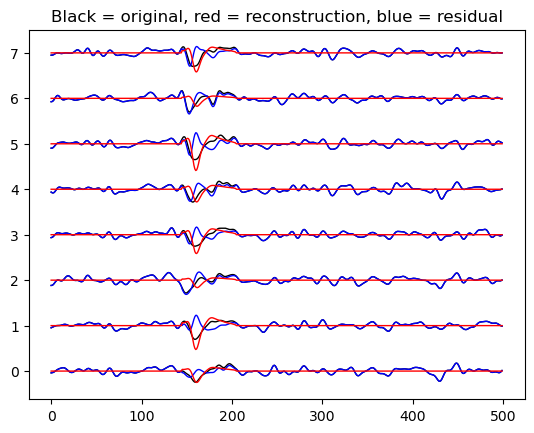

In [86]:
rec_start = rec_snip.T.copy()

waves_svd = template_lr(spk_waves)
conv_temp = convolve_lr(rec_start, waves_svd)
bm = bestmatch(conv_temp, rec_start, waves_svd)
sig_new = reconstruct(rec_start.copy(), [], bm, waves_svd)

fig, ax = plt.subplots()
multichanplot(rec_start[:,900:1400],[0,0,0],ax,offset=30)
multichanplot(sig_new['resid'][:,900:1400],[0,0,1],ax,offset=30)
multichanplot(sig_new['recon'][:,900:1400],[1,0,0],ax,offset=30)
ax.set_title('Black = original, red = reconstruction, blue = residual')

Seems reasonable. Let's do this several times and see how it goes.

Text(0.5, 0.98, 'Black = original, red = reconstruction, blue = residual')

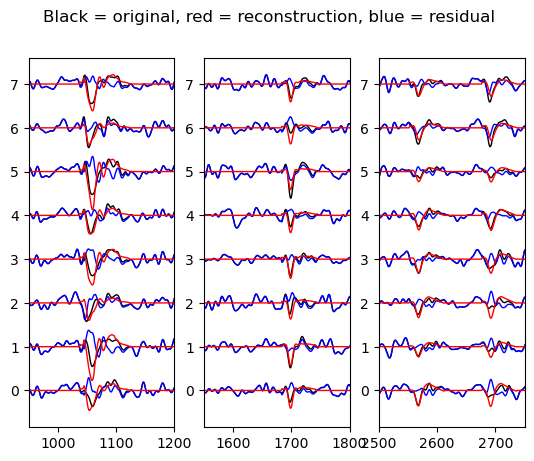

In [87]:
rec_start = rec_snip.T.copy()

waves_svd = template_lr(spk_waves)
conv_temp = convolve_lr(rec_start, waves_svd)
bm = bestmatch(conv_temp, rec_start, waves_svd)
sig_new = reconstruct(rec_start.copy(), [], bm, waves_svd)

for j in range(5):
    conv_temp = convolve_lr(sig_new['resid'], waves_svd)
    bm = bestmatch(conv_temp, sig_new['resid'], waves_svd)
    sig_new = reconstruct(sig_new['resid'].copy(), sig_new['recon'].copy(), bm, waves_svd)

fig, ax = plt.subplots(1,3)
multichanplot(rec_start,[0,0,0],ax[0],offset=20)
multichanplot(sig_new['resid'],[0,0,1],ax[0],offset=20)
multichanplot(sig_new['recon'],[1,0,0],ax[0],offset=20)
ax[0].set_xlim((950,1200))

multichanplot(rec_start,[0,0,0],ax[1],offset=20)
multichanplot(sig_new['resid'],[0,0,1],ax[1],offset=20)
multichanplot(sig_new['recon'],[1,0,0],ax[1],offset=20)
ax[1].set_xlim((1550,1800))

multichanplot(rec_start,[0,0,0],ax[2],offset=20)
multichanplot(sig_new['resid'],[0,0,1],ax[2],offset=20)
multichanplot(sig_new['recon'],[1,0,0],ax[2],offset=20)
ax[2].set_xlim((2500,2750))

plt.suptitle('Black = original, red = reconstruction, blue = residual')

Not perfect, but perfectable.